In [7]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
normalize = transforms.Normalize(mean=[0.4563, 0.4076, 0.3895], std=[0.2298, 0.2144, 0.2259])

# lisa_transforms = transforms.Compose([ transforms.ToPILImage(), transforms.Resize((224, 224)),transforms.ToTensor(),normalize])
lisa_transforms = transforms.Compose([ transforms.ToPILImage(),transforms.ToTensor(),normalize])

In [13]:
class_names = ['stop','speedlimit', 'pedestrianCrossing', 'turnLeft','slow', 'signalAhead', 'laneEnds', 'school', 'merge','yield', 'noRightTurn','noLeftTurn', 'roundabout', 'turnRight']
import torch
from torch.utils.data import Dataset

class SubsetLISA(Dataset):
    """
    A custom dataset for the LISA subset, created using filtered image and label tensors.
    """
    def __init__(self, image_tensor_path, label_tensor_path,train:bool, transform=None):
        """
        Args:
            image_tensor_path (str): Path to the images tensor file.
            label_tensor_path (str): Path to the labels tensor file.
            transform (callable, optional): A function/transform to apply to the images.
        """
        self.images = torch.load(image_tensor_path)
        self.labels = torch.load(label_tensor_path)
        self.transform = transform
        self.train = train
        self._train_test_split()

        assert len(self.images) == len(self.labels), "Images and labels length mismatch"

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is the input tensor and label is the target tensor.
        """
        image = self.images[index]
        target = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, target

    def _train_test_split(self, test_percent: float = 0.16):
        classes = {}
        for i, cl in enumerate(self.labels.numpy()):
            arr = classes.get(cl, [])
            arr.append(i)
            classes[cl] = arr

        train, test = [], []
        for cl, arr in classes.items():
            split_index = int(len(arr) * test_percent)
            test = test + arr[:split_index]
            train = train + arr[split_index:]

        sub = train if self.train else test
        self.images, self.labels = self.images[sub], self.labels[sub]


In [15]:
# Paths to the saved subset tensors
image_tensor_path = "datasets/lisa-batches/subset_images.tensor"  # Replace with your actual file path
label_tensor_path = "datasets/lisa-batches/subset_labels2.tensor"  # Replace with your actual file path

# Initialize the dataset
train_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=True, transform = lisa_transforms)
test_dataset = SubsetLISA(image_tensor_path, label_tensor_path, train=False, transform = lisa_transforms)

In [71]:
epochs = 100
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,) # num_workers=4,
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [224]:
%run models.ipynb
%run utils.ipynb
%run metrics.ipynb

# Normal Training

In [38]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_normal_subset.pth"
model_save_path = model_path / model_name
model = vgg16().to(device)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [40]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Normal is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Normal is: 97.07%


In [41]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

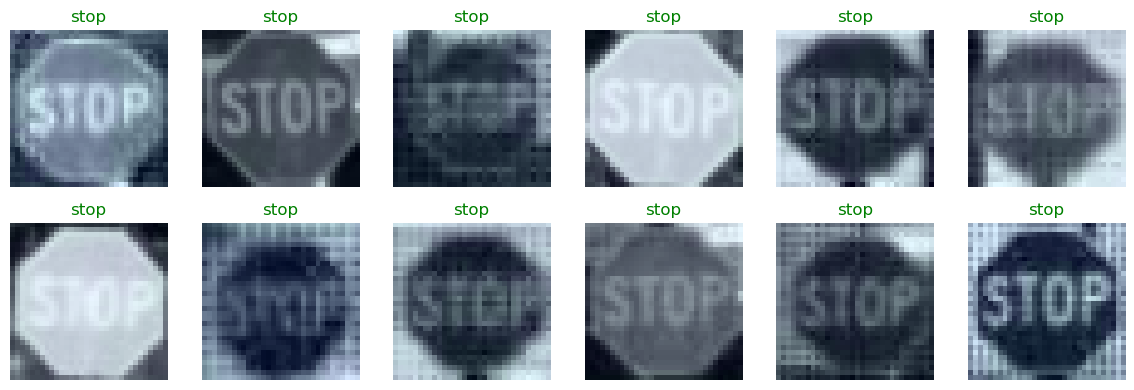

In [42]:
import matplotlib.pyplot as plt
import torch

fig = plt.figure(figsize=(12, 4))
indexes = []
rows, cols = 2, 6

for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    
    # Get the predicted label
    label_pred = torch.argmax(model(img_temp))

    # Add the subplot
    fig.add_subplot(rows, cols, i)
    
    # Permute the image tensor from (C, H, W) to (H, W, C)
    img = img.permute(1, 2, 0).cpu()  # Ensure the image is on CPU for matplotlib
    
    # Normalize the image to [0, 1] for proper visualization (if needed)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    
    # Display the image
    plt.imshow(img.numpy())  # No cmap='gray' for color images
    
    # Set the title color based on prediction correctness
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g')  # Correct prediction
    else:
        plt.title(class_names[label_pred], color='r')  # Incorrect prediction
    
    plt.axis(False)
    plt.tight_layout()

plt.show()

In [43]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [45]:
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

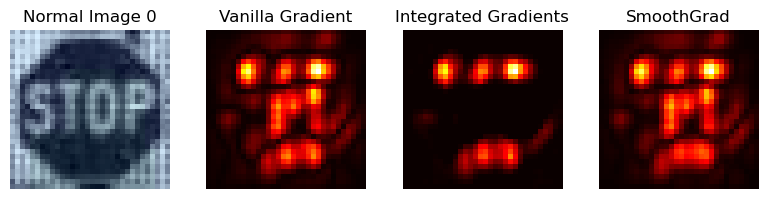

In [190]:
index = indexes[11]
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_normal')

# Adversarial Training

In [65]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_adv.pth"
model_save_path = model_path / model_name
model_adv = vgg16().to(device)
model_adv.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [67]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_adv, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Adversarial is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Adversarial is: 97.51%


In [73]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

TypeError: expected np.ndarray (got Tensor)

In [76]:
# Applying explanation methods on the model outputs
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

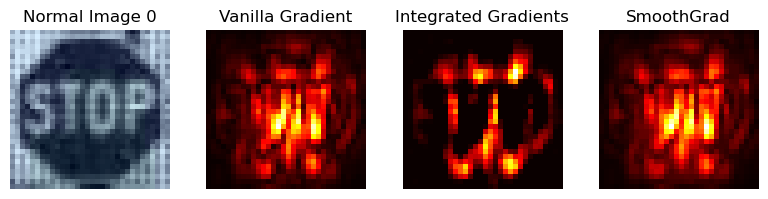

In [193]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_adv, a_batch_integrad_adv, a_batch_smoothgrad_adv, 'lisa_adversarial')

# L1 Pre Prune

In [82]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_l1_pre.pth"
model_save_path = model_path / model_name
model_l1_unstructured = vgg16().to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity_vgg(model_l1_unstructured):.2f}%")
model_l1_unstructured.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 19.64%


<All keys matched successfully>

In [84]:
# Model to GPU and eval mode.
model_l1_unstructured.to(device)
model_l1_unstructured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_l1_unstructured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned L1 UnStructure Pre is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned L1 UnStructure Pre is: 94.47%


In [86]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [88]:
# Applying explanation methods on the model outputs
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

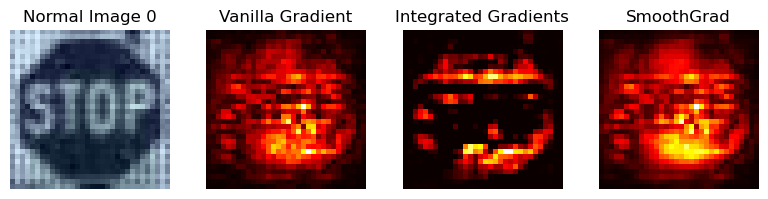

In [195]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_l1, a_batch_integrad_l1, a_batch_smoothgrad_l1, 'lisa_l1_pre')

# Post No Tune L1

In [93]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_l1_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_l1 = vgg16().to(device)

for name, module in model_no_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity_vgg(model_no_tuned_l1):.2f}%")
model_no_tuned_l1.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 19.64%


<All keys matched successfully>

In [95]:
# Model to GPU and eval mode.
model_no_tuned_l1.to(device)
model_no_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_l1, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG-16 Post no tune is: {(100 * test_acc):.2f}%")

Test accuracy for VGG-16 Post no tune is: 94.79%


In [96]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [97]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

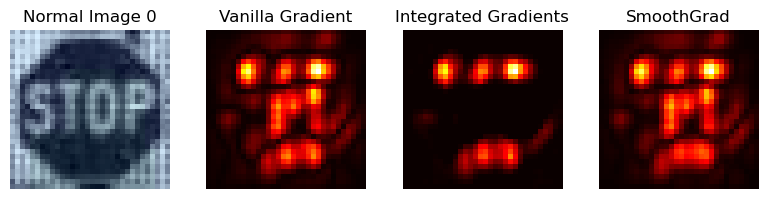

In [197]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_l1_post_no_tuned')

# Post Tuned l1

In [104]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_l1_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_l1 = vgg16().to(device)

for name, module in model_post_tuned_l1.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity_vgg(model_post_tuned_l1):.2f}%")
model_post_tuned_l1.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 19.64%


<All keys matched successfully>

In [106]:
# Model to GPU and eval mode.
model_post_tuned_l1.to(device)
model_post_tuned_l1.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_l1, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Resnet 18 Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Resnet 18 Normal is: 95.34%


In [107]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [108]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_l1).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_l1)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

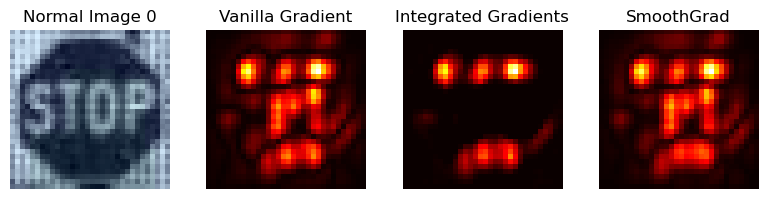

In [199]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_l1_post_tuned')

# Global Pre Prune

In [115]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_global_pre.pth"
model_save_path = model_path / model_name
model_global = vgg16().to(device)

parameters_to_prune = (
    (model_global.features[0], 'weight'),
    (model_global.features[2], 'weight'),
    (model_global.features[5], 'weight'),
    (model_global.features[7], 'weight'),
    (model_global.features[10], 'weight'),
    (model_global.features[12], 'weight'),
    (model_global.features[14], 'weight'),
    (model_global.features[17], 'weight'),
    (model_global.features[19], 'weight'),
    (model_global.features[21], 'weight'),
    (model_global.features[24], 'weight'),
    (model_global.features[26], 'weight'),
    (model_global.features[28], 'weight'),
    (model_global.classifier[1], 'weight'),
    (model_global.classifier[4], 'weight'),
    (model_global.classifier[6], 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"VGG global sparsity = {compute_sparsity_vgg(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
VGG global sparsity = 20.00%


<All keys matched successfully>

In [117]:
# Model to GPU and eval mode.
model_global.to(device)
model_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_global, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Global Pre is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Global Pre is: 93.93%


In [118]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [119]:
# Applying explanation methods on the model outputs
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

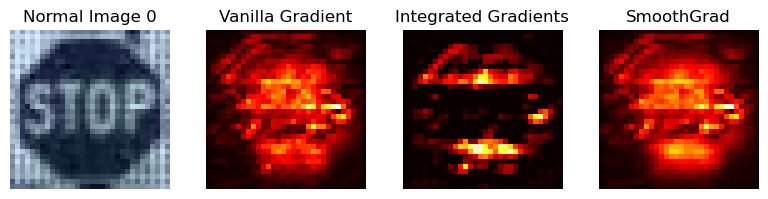

In [201]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_global, a_batch_integrad_global, a_batch_smoothgrad_global, 'lisa_global_pre')

# Global Post Prune No tune

In [126]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_global_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_global = vgg16().to(device)

parameters_to_prune = (
    (model_no_tuned_global.features[0], 'weight'),
    (model_no_tuned_global.features[2], 'weight'),
    (model_no_tuned_global.features[5], 'weight'),
    (model_no_tuned_global.features[7], 'weight'),
    (model_no_tuned_global.features[10], 'weight'),
    (model_no_tuned_global.features[12], 'weight'),
    (model_no_tuned_global.features[14], 'weight'),
    (model_no_tuned_global.features[17], 'weight'),
    (model_no_tuned_global.features[19], 'weight'),
    (model_no_tuned_global.features[21], 'weight'),
    (model_no_tuned_global.features[24], 'weight'),
    (model_no_tuned_global.features[26], 'weight'),
    (model_no_tuned_global.features[28], 'weight'),
    (model_no_tuned_global.classifier[1], 'weight'),
    (model_no_tuned_global.classifier[4], 'weight'),
    (model_no_tuned_global.classifier[6], 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity post no tune = {compute_sparsity_vgg(model_no_tuned_global):.2f}%")

model_no_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity post no tune = 20.00%


<All keys matched successfully>

In [127]:
# Model to GPU and eval mode.
model_no_tuned_global.to(device)
model_no_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Post no tune is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Post no tune is: 94.69%


In [128]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [130]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

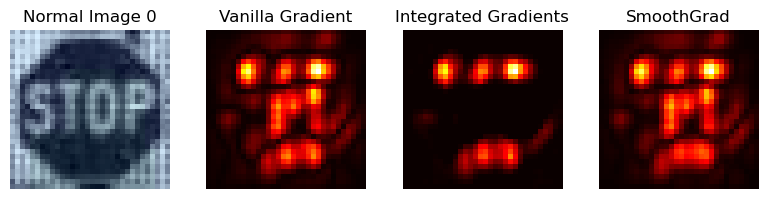

In [203]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_global_no_tune')

# Tuned Global

In [137]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_global_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_global = vgg16().to(device)

parameters_to_prune = (
    (model_post_tuned_global.features[0], 'weight'),
    (model_post_tuned_global.features[2], 'weight'),
    (model_post_tuned_global.features[5], 'weight'),
    (model_post_tuned_global.features[7], 'weight'),
    (model_post_tuned_global.features[10], 'weight'),
    (model_post_tuned_global.features[12], 'weight'),
    (model_post_tuned_global.features[14], 'weight'),
    (model_post_tuned_global.features[17], 'weight'),
    (model_post_tuned_global.features[19], 'weight'),
    (model_post_tuned_global.features[21], 'weight'),
    (model_post_tuned_global.features[24], 'weight'),
    (model_post_tuned_global.features[26], 'weight'),
    (model_post_tuned_global.features[28], 'weight'),
    (model_post_tuned_global.classifier[1], 'weight'),
    (model_post_tuned_global.classifier[4], 'weight'),
    (model_post_tuned_global.classifier[6], 'weight')
)

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"RESNET-18 global sparsity post no tune = {compute_sparsity_vgg(model_post_tuned_global):.2f}%")

model_post_tuned_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
RESNET-18 global sparsity post no tune = 20.00%


<All keys matched successfully>

In [138]:
# Model to GPU and eval mode.
model_post_tuned_global.to(device)
model_post_tuned_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_global, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Global post tuned is: {(100 * test_acc):.2f}%")

Test accuracy for Global post tuned is: 95.44%


In [140]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [141]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_global)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

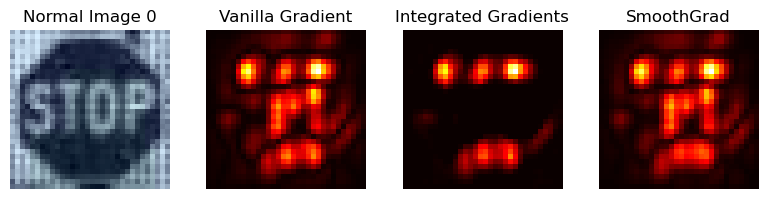

In [205]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_global_post_tuned')

# Layered Pre

In [213]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_layered_pre.pth"
model_save_path = model_path / model_name
model_structured = vgg16().to(device)

# # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity_vgg(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(model_save_path))


VGG global sparsity = 9.98%


<All keys matched successfully>

In [214]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Pre Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Pre Layered Structure is: 91.32%


In [215]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [219]:
# Applying explanation methods on the model outputs
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

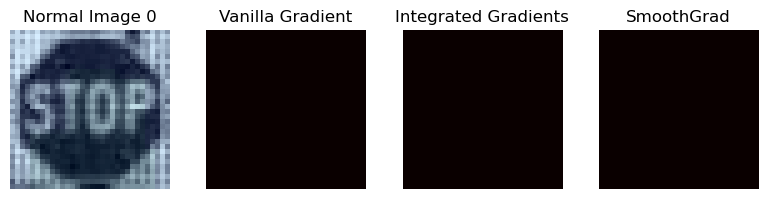

In [226]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_structured, a_batch_integrad_structured, a_batch_smoothgrad_structured, 'lisa_layered_pre')

# Layered Post No Tune

In [152]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_layered_post_notune.pth"
model_save_path = model_path / model_name
model_no_tuned_layered = vgg16().to(device)
        
# Prune layer-wise in a structured manner-
prune.ln_structured(model_no_tuned_layered.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_no_tuned_layered.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity_vgg(model_no_tuned_layered):.2f}%")

model_no_tuned_layered.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 9.98%


<All keys matched successfully>

In [153]:
# Model to GPU and eval mode.
model_no_tuned_layered.to(device)
model_no_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_no_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG POST Layeredis: {(100 * test_acc):.2f}%")

Test accuracy for VGG POST Layeredis: 93.82%


In [154]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [155]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_no_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_no_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

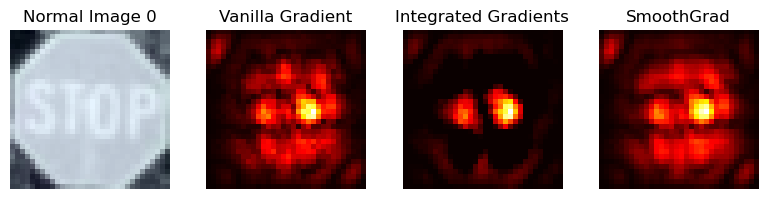

In [156]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_layered_no_tune')

# Layered Tuned

In [158]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lisa_layered_post_tuned.pth"
model_save_path = model_path / model_name
model_post_tuned_layered = vgg16().to(device)
        
# Prune layer-wise in a structured manner-
prune.ln_structured(model_post_tuned_layered.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_post_tuned_layered.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity_vgg(model_post_tuned_layered):.2f}%")

model_post_tuned_layered.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 9.98%


<All keys matched successfully>

In [159]:
# Model to GPU and eval mode.
model_post_tuned_layered.to(device)
model_post_tuned_layered.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_post_tuned_layered, test_dataloader, device)

test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Layered Tuned is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Layered Tuned is: 94.90%


In [160]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [161]:
gc.collect()
torch.cuda.empty_cache()
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
gc.collect()
torch.cuda.empty_cache()
a_batch_saliency = Saliency(model_post_tuned_layered).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
gc.collect()
torch.cuda.empty_cache()
saliency = Saliency(model_post_tuned_layered)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

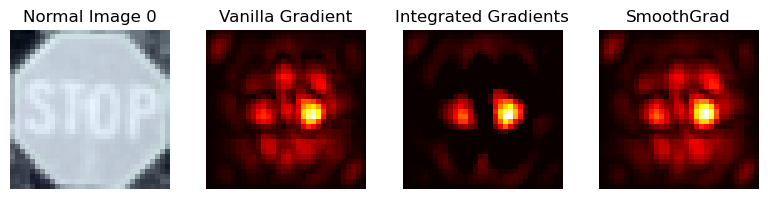

In [162]:
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lisa_layered_post_tuned')

In [ ]:
def explainer_wrapper(**kwargs):
    """
    A wrapper function to call the appropriate explanation method.

    """
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    """
    Generate explanations for a model's predictions using the SmoothGrad method.

    Args:
        model: The model to explain.
        inputs : Input samples.
        targets: Target labels corresponding to the inputs.
        abs : Whether to use the absolute value of gradients.
        normalise: Whether to normalize the explanation
        stdevs: Standard deviation of the noise added to inputs
        nt_samples: Number of noisy samples to generate for SmoothGrad.

    Returns:
        numpy.ndarray: Explanation maps for the input samples.
    """
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 32),kwargs.get("img_size", 32),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 32),
                kwargs.get("img_size", 32),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

In [ ]:
xai_method=["SmoothGrad"]

In [ ]:
gc.collect()
torch.cuda.empty_cache()

# ROAD VANILLA GRADIENT

In [ ]:
result_normal = 
result_adv = 
result_l1_pre = 
result_no_tuned_l1 =
result_post_tuned_l1 =
result_global_pre =
result_no_tuned_global=
result_post_tuned_global=
result_pre_tuned_layered=
result_post_no_tuned_layered=
result_post_tuned_layered=

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='-', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LISA_VANILLA_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# ROAD INTEGRATED GRADIENT

In [ ]:
result_normal = 
result_adv = 
result_l1_pre = 
result_no_tuned_l1 =
result_post_tuned_l1 =
result_global_pre =
result_no_tuned_global=
result_post_tuned_global=
result_pre_tuned_layered=
result_post_no_tuned_layered=
result_post_tuned_layered=

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='-', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LISA__IG_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD SMOOTHGRAD

In [ ]:
result_normal = 
result_adv = 
result_l1_pre = 
result_no_tuned_l1 =
result_post_tuned_l1 =
result_global_pre =
result_no_tuned_global=
result_post_tuned_global=
result_pre_tuned_layered=
result_post_no_tuned_layered=
result_post_tuned_layered=

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1_pre.values()), label='L1 Pre', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_l1.values()), label='L1 No Tune', linestyle='--', marker='x', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_l1.values()), label='L1 Tuned', linestyle='--', marker='*', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global_pre.values()), label='Global Pre', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_no_tuned_global.values()), label='Global No Tune', linestyle='--', marker='+', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_global.values()), label='Global Tuned', linestyle='--', marker='>', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_pre_tuned_layered.values()), label='Layered Pre', linestyle='--', marker='D', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_no_tuned_layered.values()), label='Layered No Tune', linestyle='--', marker='<', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_post_tuned_layered.values()), label='Layered Tuned', linestyle='--', marker='-', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LISA__SMOOTH_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# INPUT STABILITY

In [239]:
normal_input_saliency =
normal_input_ig =
normal_input_smooth =

adversarial_input_saliency =
adversarial_input_ig =
adversarial_input_smooth =

l1_pre_input_saliency =
l1_pre_input_ig =
l1_pre_input_smooth =

l1_post_no_tune_input_saliency =
l1_post_no_tune_input_ig =
l1_post_no_tune_input_smooth =

l1_post_tune_input_saliency =
l1_post_tune_input_ig =
l1_post_tune_input_smooth =

global_pre_input_saliency =
global_pre_input_ig =
global_pre_input_smooth =

global_no_tune_input_saliency =
global_no_tune_input_ig =
global_no_tune_input_smooth =

global_tune_input_saliency =
global_tune_input_ig =
global_tune_input_smooth =

layered_pre_input_saliency =
layered_pre_tune_input_ig =
layered_pre_tune_input_smooth =

layered_no_tune_input_saliency =
layered_no_tune_input_ig =
layered_no_tune_input_smooth =

layered_tune_input_saliency =
layered_tune_input_ig =
layered_tune_input_smooth =

SyntaxError: invalid syntax (3640764428.py, line 1)

In [ ]:
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_pre_input_saliency, l1_post_no_tune_input_saliency, l1_post_tune_input_saliency,global_pre_input_saliency, global_no_tune_input_saliency,global_tune_input_saliency, layered_pre_input_saliency,layered_no_tune_input_saliency, layered_tune_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_pre_input_ig, l1_post_no_tune_input_ig, l1_post_tune_input_ig,global_pre_input_ig,global_no_tune_input_ig,global_tune_input_ig, layered_pre_tune_input_ig, layered_no_tune_input_ig, layered_tune_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_pre_input_smooth, l1_post_no_tune_input_smooth, l1_post_tune_input_smooth, global_pre_input_smooth, global_no_tune_input_smooth, global_tune_input_smooth, layered_pre_tune_input_smooth, layered_no_tune_input_smooth, layered_tune_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

# OUTPUT STABILITY

In [ ]:
normal_output_saliency =
normal_output_ig =
normal_output_smooth =

adversarial_output_saliency =
adversarial_output_ig =
adversarial_output_smooth =

l1_pre_output_saliency =
l1_pre_output_ig =
l1_pre_output_smooth =

l1_post_no_tune_output_saliency =
l1_post_no_tune_output_ig =
l1_post_no_tune_output_smooth =

l1_post_tune_output_saliency =
l1_post_tune_output_ig =
l1_post_tune_output_smooth =

global_pre_output_saliency =
global_pre_output_ig =
global_pre_output_smooth =

global_no_tune_output_saliency =
global_no_tune_output_ig =
global_no_tune_output_smooth =

global_tune_output_saliency =
global_tune_output_ig =
global_tune_output_smooth =

layered_pre_output_saliency =
layered_pre_tune_output_ig =
layered_pre_tune_output_smooth =

layered_no_tune_output_saliency =
layered_no_tune_output_ig =
layered_no_tune_output_smooth =

layered_tune_output_saliency =
layered_tune_output_ig =
layered_tune_output_smooth =

In [ ]:
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_pre_output_saliency, l1_post_no_tune_output_saliency, l1_post_tune_output_saliency,global_pre_output_saliency, global_no_tune_output_saliency,global_tune_output_saliency, layered_pre_output_saliency,layered_no_tune_output_saliency, layered_tune_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_pre_output_ig, l1_post_no_tune_output_ig, l1_post_tune_output_ig,global_pre_output_ig,global_no_tune_output_ig,global_tune_output_ig, layered_pre_tune_output_ig, layered_no_tune_output_ig, layered_tune_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_pre_output_smooth, l1_post_no_tune_output_smooth, l1_post_tune_output_smooth, global_pre_output_smooth, global_no_tune_output_smooth, global_tune_output_smooth, layered_pre_tune_output_smooth, layered_no_tune_output_smooth, layered_tune_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

In [ ]:
# SPARSITY 

In [ ]:
normal_sparsity_saliency =
normal_sparsity_ig =
normal_sparsity_smooth =

adversarial_sparsity_saliency =
adversarial_sparsity_ig =
adversarial_sparsity_smooth =

l1_pre_sparsity_saliency =
l1_pre_sparsity_ig =
l1_pre_sparsity_smooth =

l1_post_no_tune_sparsity_saliency =
l1_post_no_tune_sparsity_ig =
l1_post_no_tune_sparsity_smooth =

l1_post_tune_sparsity_saliency =
l1_post_tune_sparsity_ig =
l1_post_tune_sparsity_smooth =

global_pre_sparsity_saliency =
global_pre_sparsity_ig =
global_pre_sparsity_smooth =

global_no_tune_sparsity_saliency =
global_no_tune_sparsity_ig =
global_no_tune_sparsity_smooth =

global_tune_sparsity_saliency =
global_tune_sparsity_ig =
global_tune_sparsity_smooth =

layered_pre_sparsity_saliency =
layered_pre_tune_sparsity_ig =
layered_pre_tune_sparsity_smooth =

layered_no_tune_sparsity_saliency =
layered_no_tune_sparsity_ig =
layered_no_tune_sparsity_smooth =

layered_tune_sparsityt_saliency =
layered_tune_sparsity_ig =
layered_tune_sparsity_smooth =

In [ ]:
vanilla_gradient = [normal_sparsity_saliency, adversarial_sparsity_saliency, l1_pre_sparsity_saliency, l1_post_no_tune_sparsity_saliency, l1_post_tune_sparsity_saliency,global_pre_sparsity_saliency, global_no_tune_sparsity_saliency,global_tune_sparsity_saliency, layered_pre_sparsity_saliency,layered_no_tune_sparsity_saliency, layered_tune_sparsity_saliency]
integrated_gradients = [normal_sparsity_ig, adversarial_sparsity_ig, l1_pre_sparsity_ig, l1_post_no_tune_sparsity_ig, l1_post_tune_sparsity_ig,global_pre_sparsity_ig,global_no_tune_sparsity_ig,global_tune_sparsity_ig, layered_pre_tune_sparsity_ig, layered_no_tune_sparsity_ig, layered_tune_sparsity_ig]
smoothgrad = [normal_sparsity_smooth, adversarial_sparsity_smooth, l1_pre_sparsity_smooth, l1_post_no_tune_sparsity_smooth, l1_post_tune_sparsity_smooth, global_pre_sparsity_smooth, global_no_tune_sparsity_smooth, global_tune_sparsity_smooth, layered_pre_tune_sparsity_smooth, layered_no_tune_sparsity_smooth, layered_tune_sparsityt_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Pre Prune","L1 No Tune Prune", "L1 Tuned Prune", "Global Pre Prune","Global No Tune Prune","Global Tuned Prune", "Layered Pre Prune","Layered No Tune Prune","Layered Tuned Prune"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)